In [29]:
from getpass import getpass

# Prompt for token securely
token = getpass('Enter your GitHub personal access token: ')

# Clone using token authentication
!git clone https://{token}@github.com/pabasara-samarakoon-4176/MDT_prediction.git

Enter your GitHub personal access token: ··········
Cloning into 'MDT_prediction'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 2), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 24.32 KiB | 12.16 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/

In [31]:
!cp /content/fyp_model_v2.ipynb /content/MDT_prediction/

cp: cannot stat '/content/fyp_model_v2.ipynb': No such file or directory


In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/Sri-Lanka.csv')
df.head()

,Cell_ID,Cell Name,RSRP,RSRQ,Geohash,EARFCN_DL,Latitude_of_MDT,Longitude_of_MDT,MR_Count,Site ID,...,oneway,bridge,layer,source,name:si,name:ta,osm_id,osm_type,Road_Coverage,Population_Density
0,5215253,Mannar_SLT-MA0001-H_2B,-100.0,-13.0,tc8g466m,1650,8.978096,79.906923,2,MA0001,...,NaN,NaN,NaN,NaN,NaN,NaN,156298074.0,ways_line,1,3291.916504
1,5215253,Mannar_SLT-MA0001-H_2B,-100.0,-13.0,tc8g466m,1650,8.978096,79.906923,2,MA0001,...,NaN,NaN,NaN,NaN,NaN,NaN,197793816.0,ways_line,1,3291.916504
2,5215253,Mannar_SLT-MA0001-H_2B,-100.0,-13.0,tc8g466m,1650,8.978096,79.906923,2,MA0001,...,NaN,NaN,NaN,NaN,NaN,NaN,197793916.0,ways_line,1,3291.916504
3,5215253,Mannar_SLT-MA0001-H_2B,-100.0,-13.0,tc8g466m,1650,8.978096,79.906923,2,MA0001,...,NaN,NaN,NaN,NaN,NaN,NaN,197793699.0,ways_line,1,3291.916504
4,5215253,Mannar_SLT-MA0001-H_2B,-100.0,-13.0,tc8g466m,1650,8.978096,79.906923,2,MA0001,...,NaN,NaN,NaN,NaN,NaN,NaN,156298067.0,ways_line,1,3291.916504


In [4]:
df.columns

Index(['Cell_ID', 'Cell Name', 'RSRP', 'RSRQ', 'Geohash', 'EARFCN_DL',
       'Latitude_of_MDT', 'Longitude_of_MDT', 'MR_Count', 'Site ID',
       'Site Name (from MAIN DATA)', 'Cell ID', 'Antenna Height', 'Azimuth',
       'E Tilt', 'M Tilt', 'Tilt', 'Latitude_of_Site', 'Longitude_of_Site',
       'MDT height from MSL', 'Site height from MSL', 'Height Difference',
       'Horizontal Distance', 'Angle_from_North',
       'Azimuth_to_nearest_5_degrees', 'Reduced_Amount', 'Normalized_Azimuth',
       'Latitude_Difference', 'Longitude_Difference', 'name', 'name:en',
       'highway', 'surface', 'smoothness', 'width', 'lanes', 'oneway',
       'bridge', 'layer', 'source', 'name:si', 'name:ta', 'osm_id', 'osm_type',
       'Road_Coverage', 'Population_Density'],
      dtype='object')

In [5]:
features = ['EARFCN_DL', 'Latitude_of_MDT', 'Longitude_of_MDT',
            'MR_Count', 'Antenna Height', 'Azimuth', 'Tilt',
            'Latitude_of_Site', 'Longitude_of_Site',
            'Road_Coverage', 'Population_Density']

target = ['RSRP']

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np

# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

rsrp_scaler = StandardScaler()
df['RSRP_norm'] = rsrp_scaler.fit_transform(df[target])

# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert to torch tensors
def prepare_tensor(dataframe):
    input_tensor = torch.tensor(dataframe[features].values, dtype=torch.float32)
    pos_tensor = torch.tensor(dataframe[['Latitude_of_MDT', 'Longitude_of_MDT']].values, dtype=torch.float32)
    target_tensor = torch.tensor(dataframe['RSRP_norm'].values, dtype=torch.float32).view(-1, 1)
    return input_tensor, pos_tensor, target_tensor

X_train, pos_train, y_train = prepare_tensor(train_df)
X_test, pos_test, y_test = prepare_tensor(test_df)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, S, D = x.shape
        qkv = self.qkv_proj(x).reshape(B, S, self.num_heads, 3 * self.d_k).transpose(1, 2)
        Q, K, V = qkv.chunk(3, dim=-1)
        scores = Q @ K.transpose(-2, -1) / np.sqrt(self.d_k)
        attn = F.softmax(scores, dim=-1)
        context = attn @ V
        context = context.transpose(1, 2).reshape(B, S, D)
        return self.out_proj(context)

In [16]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout(self.attn(x)))
        return self.norm2(x + self.dropout(self.ff(x)))

In [17]:
class RSRPTransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, num_heads=4, num_layers=2, d_ff=128):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_proj = nn.Linear(2, d_model)
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x, pos):
        x = self.input_proj(x).unsqueeze(1) + self.pos_proj(pos).unsqueeze(1)
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x).squeeze(1)

In [18]:
model = RSRPTransformerModel(input_dim=len(features))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
loss_values = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train, pos_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

    print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.1827
Epoch [2/100], Loss: 0.1812
Epoch [3/100], Loss: 0.1778
Epoch [4/100], Loss: 0.1878
Epoch [5/100], Loss: 0.1820
Epoch [6/100], Loss: 0.1810
Epoch [7/100], Loss: 0.1797
Epoch [8/100], Loss: 0.1908
Epoch [9/100], Loss: 0.1904
Epoch [10/100], Loss: 0.1777
Epoch [11/100], Loss: 0.1802
Epoch [12/100], Loss: 0.1877
Epoch [13/100], Loss: 0.1698
Epoch [14/100], Loss: 0.1893
Epoch [15/100], Loss: 0.1943
Epoch [16/100], Loss: 0.1726
Epoch [17/100], Loss: 0.1824
Epoch [18/100], Loss: 0.1775
Epoch [19/100], Loss: 0.1700
Epoch [20/100], Loss: 0.1751
Epoch [21/100], Loss: 0.1815
Epoch [22/100], Loss: 0.1773
Epoch [23/100], Loss: 0.1784
Epoch [24/100], Loss: 0.2001
Epoch [25/100], Loss: 0.1742
Epoch [26/100], Loss: 0.1766
Epoch [27/100], Loss: 0.1765
Epoch [28/100], Loss: 0.1807
Epoch [29/100], Loss: 0.1728
Epoch [30/100], Loss: 0.1717
Epoch [31/100], Loss: 0.1683
Epoch [32/100], Loss: 0.1733
Epoch [33/100], Loss: 0.1693
Epoch [34/100], Loss: 0.1671
Epoch [35/100], Loss: 0

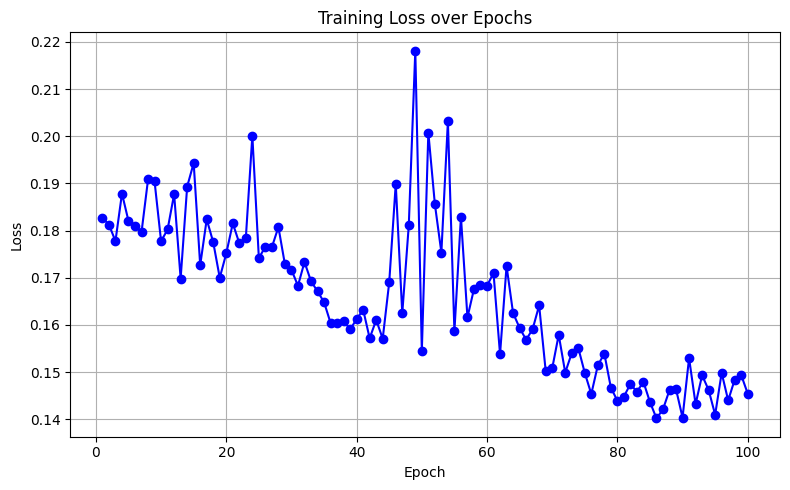

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test, pos_test)
    test_loss = criterion(test_preds, y_test)
    print(f"\nTest Loss (MSE): {test_loss.item():.4f}")

    # Reverse normalization to get actual RSRP values
    preds_actual = rsrp_scaler.inverse_transform(test_preds.view(-1, 1).numpy())
    target_actual = rsrp_scaler.inverse_transform(y_test.view(-1, 1).numpy())

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    print(f"MAE: {mean_absolute_error(target_actual, preds_actual):.2f}")
    print(f"RMSE: {mean_squared_error(target_actual, preds_actual):.2f}")
    print(f"R² Score: {r2_score(target_actual, preds_actual):.2f}")


Test Loss (MSE): 0.4724
MAE: 11.48
RMSE: 428.08
R² Score: 0.56
